In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from utils import *

In [23]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def sparse_rank_estimation(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))
    D = sp.diags(A.sum(axis=1).A.flatten(), format='csr')
    L = D - A.tocsr()
    eigvals, _ = spla.eigsh(L, k=num_nodes // 2, sigma=0.0, which='SM')
    rank = np.sum(eigvals > 1e-10)
    return rank

def sparse_trace_estimation(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))
    D = sp.diags(A.sum(axis=1).A.flatten(), format='csr')
    L = D - A.tocsr()
    trace = L.diagonal().sum()
    return trace

def sparse_abs_trace_estimation(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))
    D = sp.diags(A.sum(axis=1).A.flatten(), format='csr')
    L = D - A.tocsr()
    trace = np.abs(L.diagonal()).sum()
    return trace

In [24]:
dataset_name_ls = ['CoraGraphDataset', 'CiteseerGraphDataset', 'PubmedGraphDataset', 'OGB_MAG']
trace_type_ls = ['Feature', 'Laplacian']
exclusion_type_ls = ['Largest', 'Smallest']
sample_rate_ls = torch.linspace(0.5, 1, 5)
trace_rst = {}

for dataset_name in dataset_name_ls:
    data = dataset_name2dataset(dataset_name, path='data/')
    rank_ls = []
    trace_ls = []
    trace_rst[dataset_name] = {}
    for trace_type in trace_type_ls:
        trace_rst[dataset_name][trace_type] = {}
        for exclusion_type in exclusion_type_ls:
            trace_rst[dataset_name][trace_type][exclusion_type] = []
            cached_indices_path = f"SAGE_GCN/cache/{dataset_name}_{trace_type}_score_descending_indices.pt"
            sampler = Cached_Sampler(dataset_name, trace_type, exclusion_type, cached_indices_path)
            for sample_rate in sample_rate_ls:
                sampled_data = sampler.sample(data, sample_rate=sample_rate)
                # rank = sparse_rank_estimation(sampled_data)
                # rank_ls.append(rank)
                trace = sparse_trace_estimation(sampled_data)
                trace_rst[dataset_name][trace_type][exclusion_type].append(trace)
# random sampling
random_sampler = RandomSampler()
for dataset_name in dataset_name_ls:
    data = dataset_name2dataset(dataset_name, path='data/')
    trace_rst[dataset_name]['Random'] = []
    for sample_rate in sample_rate_ls:
        sampled_data = random_sampler.sample(data, sample_rate=sample_rate)
        trace = sparse_trace_estimation(sampled_data)
        trace_rst[dataset_name]['Random'].append(trace)
        abs_trace = sparse_abs_trace_estimation(sampled_data)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60


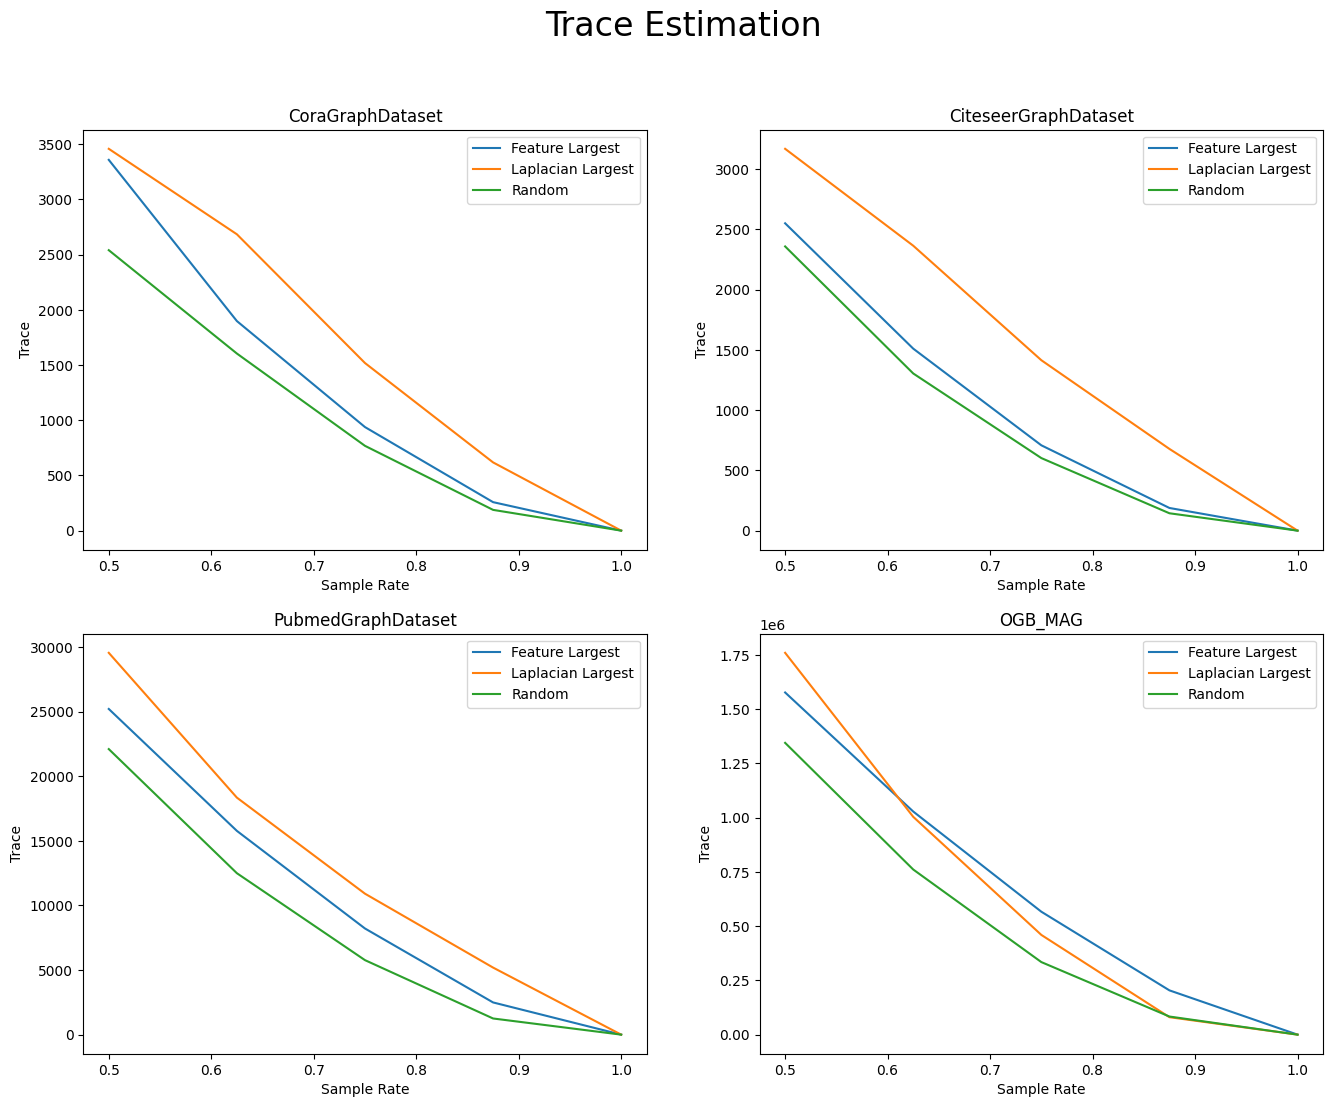

In [26]:
# plot
plt.figure(figsize=(16, 12))
for _, dataset_name in enumerate(dataset_name_ls):
    plt.subplot(2, 2, _+1)
    for trace_type in trace_type_ls:
        for exclusion_type in exclusion_type_ls:
            if exclusion_type == 'Smallest':
                continue
            plt.plot(sample_rate_ls, trace_rst[dataset_name][trace_type][exclusion_type], label=f"{trace_type} {exclusion_type}")
    plt.plot(sample_rate_ls, trace_rst[dataset_name]['Random'], label='Random')
    plt.title(dataset_name)
    plt.xlabel('Sample Rate')
    plt.ylabel('Trace')
    plt.legend()
plt.suptitle('Trace Estimation', fontsize=24)
plt.savefig("img/trace_estimation.png")